# 1. Imports

In [3]:
import pandas as pd 
import inflection
import math
import seaborn as sns
import datetime
import numpy as np
import xgboost as xgb
import random
import pickle
import requests

from flask import Flask, request, Response
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from IPython.core.display import HTML
from tabulate import tabulate
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso


## 1.1 Helping functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container {width: 100% !important;} </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [123]:
#jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/raianna/.pyenv/versions/3.8.1/envs/DSemProducao/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
# Cramer V é usado para calcular a correlação entre variáveis categóricas

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [4]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat / y))

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs(y-yhat)/y)



def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])



In [5]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        
        if verbose:
       
            print('\nKFold Number: {}'.format(k))

        # Start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # Filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # -- Training and validation dataset --

        #Training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        #Validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        #Prediction
        yhat = m.predict(xvalidation)

        #Performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
    
        #Store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Model Name': model_name,
                       'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                       'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                       'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

## 1.2 Loading data

In [6]:
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 2. Descrição dos Dados

In [11]:
#sempre bom fazer uma cópia do df quando mudar de sessão para não ter que rodar tudo de novo se der algum erro
df1 = df_raw.copy()

## 2.1 Rename columns

In [14]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old)) #a função map() vai aplicar a função snakecase na lista cols_old


df1.columns = cols_new


## 2.2. Data dimensions

In [9]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of columns: {df1.shape[1]}')

number of rows: 1017209
number of columns: 18


## 2.3 Data types

In [16]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 2.5 Fillout NA

In [12]:
df1['competition_distance'].max()

75860.0

In [17]:
#competition distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x) #200000 é muito maior que a distancia maxima que ja existe


#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#          tem que ter axis=1 porque ta usando mais de uma coluna do df, tem que explictar que o apply tem que correr nas colunas


#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


#promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True) #o inplace=True não retorna valor, só substitui no local

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else
                                                            1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 2.6 Changing types

In [18]:
df1['competition_distance'] = df1['competition_distance'].astype(np.int64)
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

## 2.7 Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [16]:
#Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenate

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index() 
m.columns = ['features', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


### 2.7.2 Categorical statistical

### 2.7.1 Numerical statistical

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

/tmp/ipykernel_6468/1742062650.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


<AxesSubplot: xlabel='assortment', ylabel='sales'>

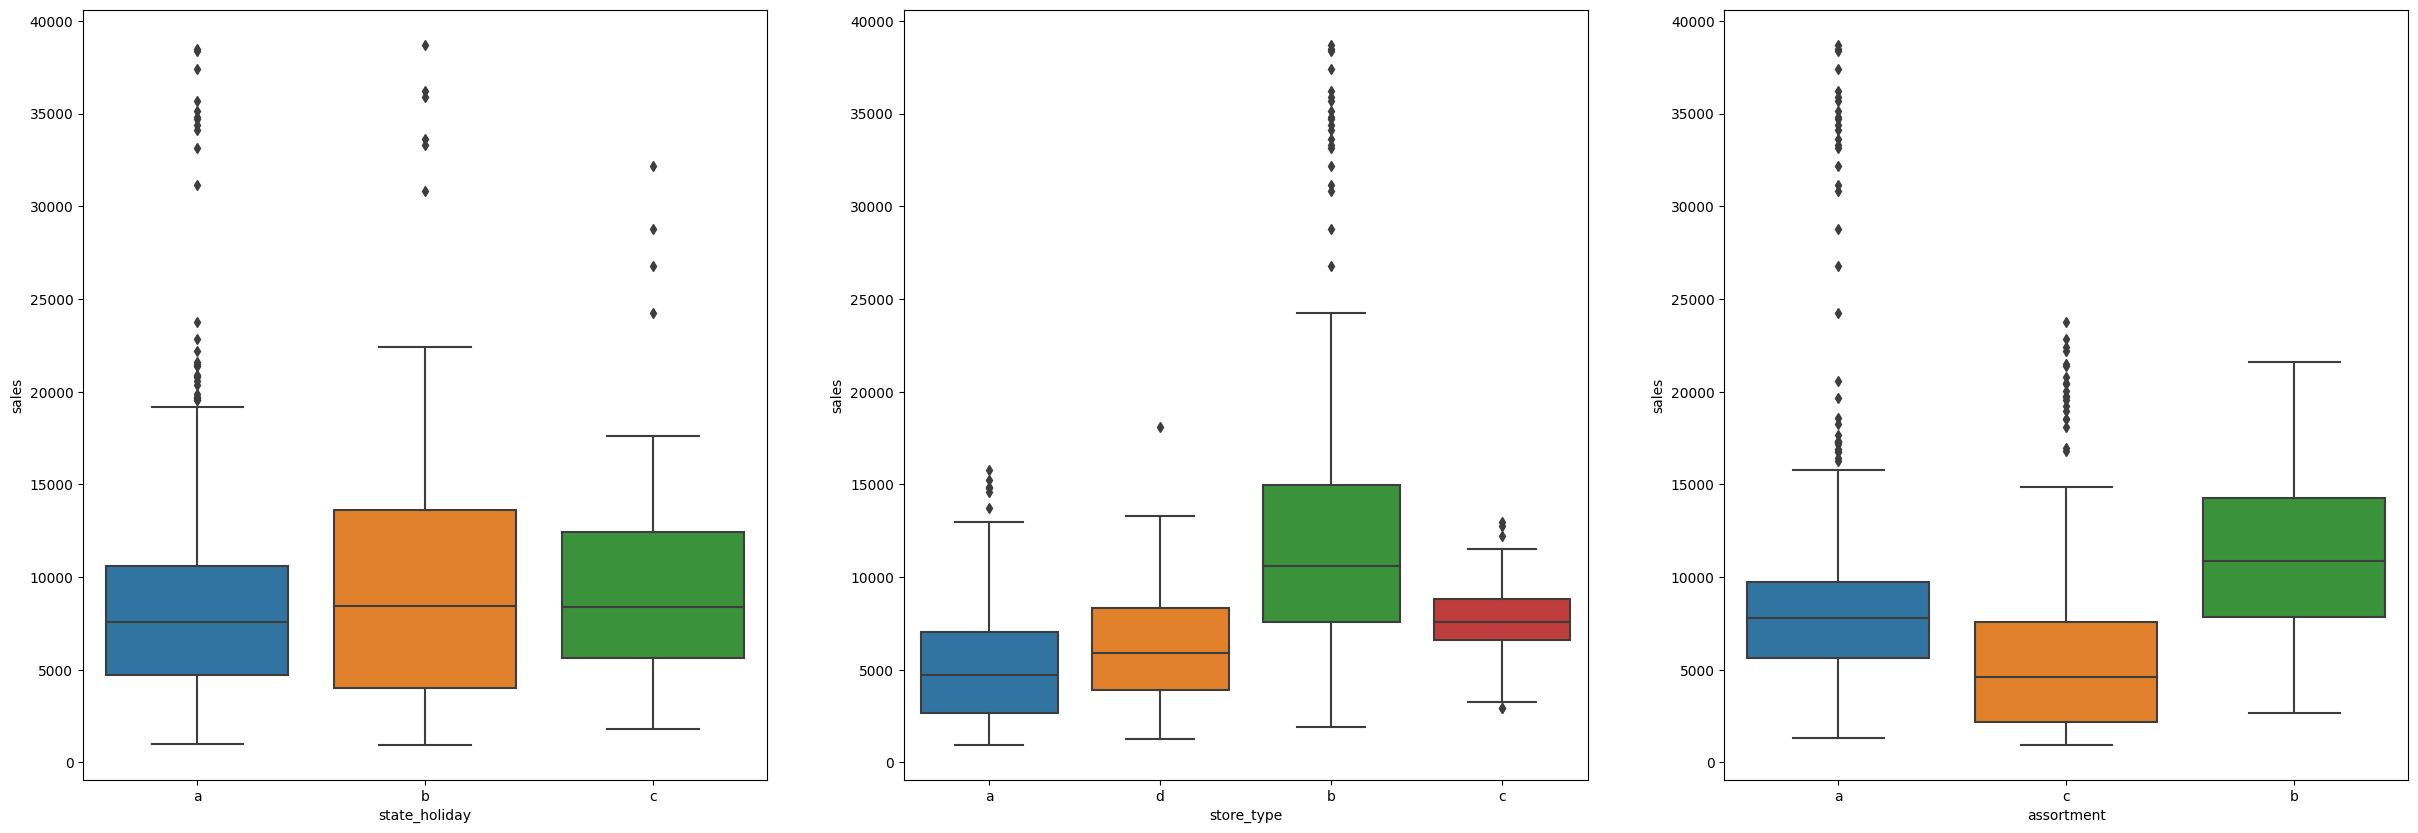

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)] #excluindo as linhas cujas colunas state_holiday e sales são 0

fig, ax=plt.subplots(figsize=(30, 10))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)


# 3. Feature Engineering

## Mapa Mental

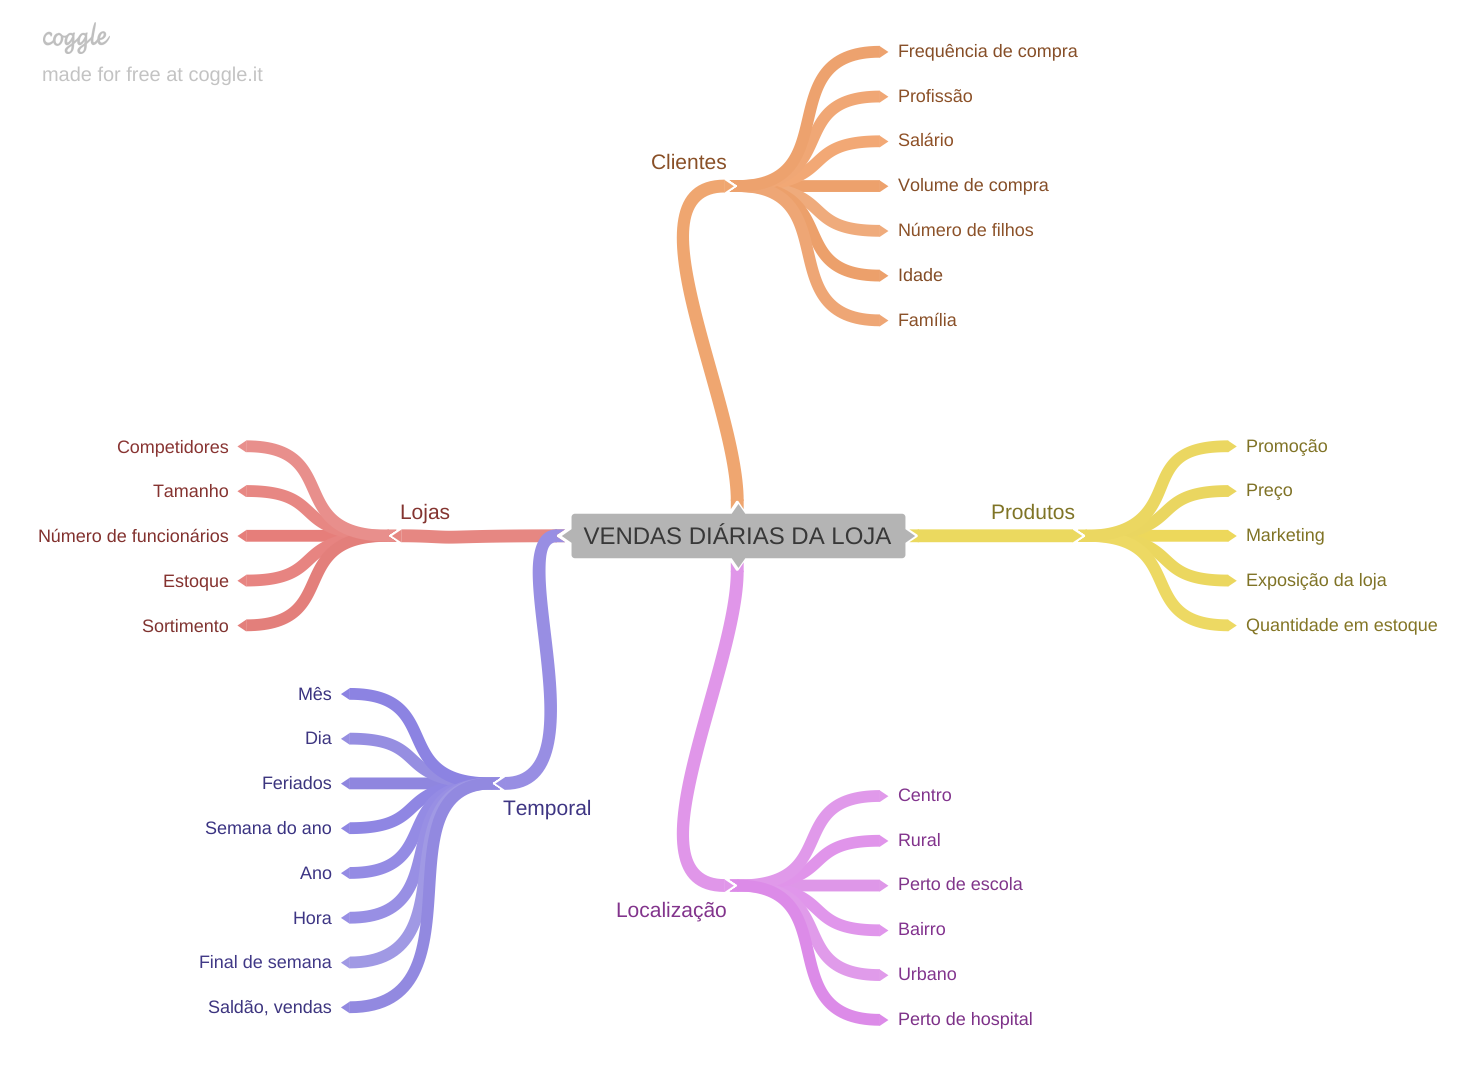

In [19]:
# Mapa mental de hipóteses - sempre fazer o mapa para tirar hipóteses
Image('mapa_mental.png')

## 3.1 Criação de hipóteses

### 3.1.1 Hipóteses lojas

**1.** Lojas com maior quadro de funcionários deveriam vender mais;

**2.** Lojas com maior estoque deveriam vender mais;

**3.** Lojas com maior porte deveriam vender mais;

**4.** Lojas com maior sortimento deveriam vender mais;

**5.** Lojas com competidores mais próximos deveriam vender menos;

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 3.1.2 Hipóteses produto

**1.** Lojas que investem mais em marketing deveriam vender mais;

**2.** Lojas que expõem mais os produtos nas vitrines deveriam vender mais;

**3.** Lojas que têm preços menores deveriam vender mais;

**4.** Lojas que têm preços menores por mais tempo deveriam vender mais;

**5.** Lojas com promoções mais agrassivas (descontos maiores) deveriam vender mais;

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais;

**7.** Lojas com mais dias de promoção deveriam vender mais;

**8.** Lojas com mais promoções consecutivas deveriamm vender mais.


### 3.1.3 Hipóteses tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais;

**2.** Lojas deveriam vender mais ao longo dos anos;

**3.** Lojas deveriam vender mais no segundo semestre do ano;

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês;

**5.** Lojas deveriam vender menos aos finais de semana;

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 3.3 Lista Final de Hipóteses

Lista de prioridades, de acordo com os dados que já temos disponível.

**1.** Lojas com maior sortimento deveriam vender mais;

**2.** Lojas com competidores mais próximos deveriam vender menos;

**3.** Lojas com competidores à mais tempo deveriam vender mais;

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais;

**5.** Lojas com mais dias de promoção deveriam vender mais;

**6.** Lojas com mais promoções consecutivas deveriamm vender mais;

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais;

**8.** Lojas deveriam vender mais ao longo dos anos;

**9.** Lojas deveriam vender mais no segundo semestre do ano;

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês;

**11.** Lojas deveriam vender menos aos finais de semana;

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 3.4 Feature Engineering

In [20]:
df2 = df1.copy()

In [21]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                 month = x['competition_open_since_month'], 
                                                                 day = 1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# Promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# State holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

## 3.5 Filtragem de variável

In [22]:
df3 = df2.copy()

### Filtragem das linhas

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]
# loja fechada não vende


### Seleção das colunas 

In [24]:
df3 = df3.drop(['customers', 'open', 'promo_interval', 'month_map'], axis=1)

# 4. Análise Exploratória dos Dados

In [25]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response variable

<Figure size 4000x2000 with 0 Axes>

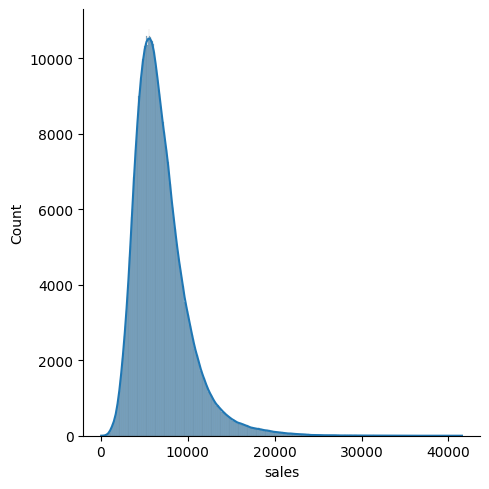

In [26]:
plt.figure(figsize=(40,20))
fig = sns.displot(df4['sales'], kde=True)


### 4.1.2 Numerical variable

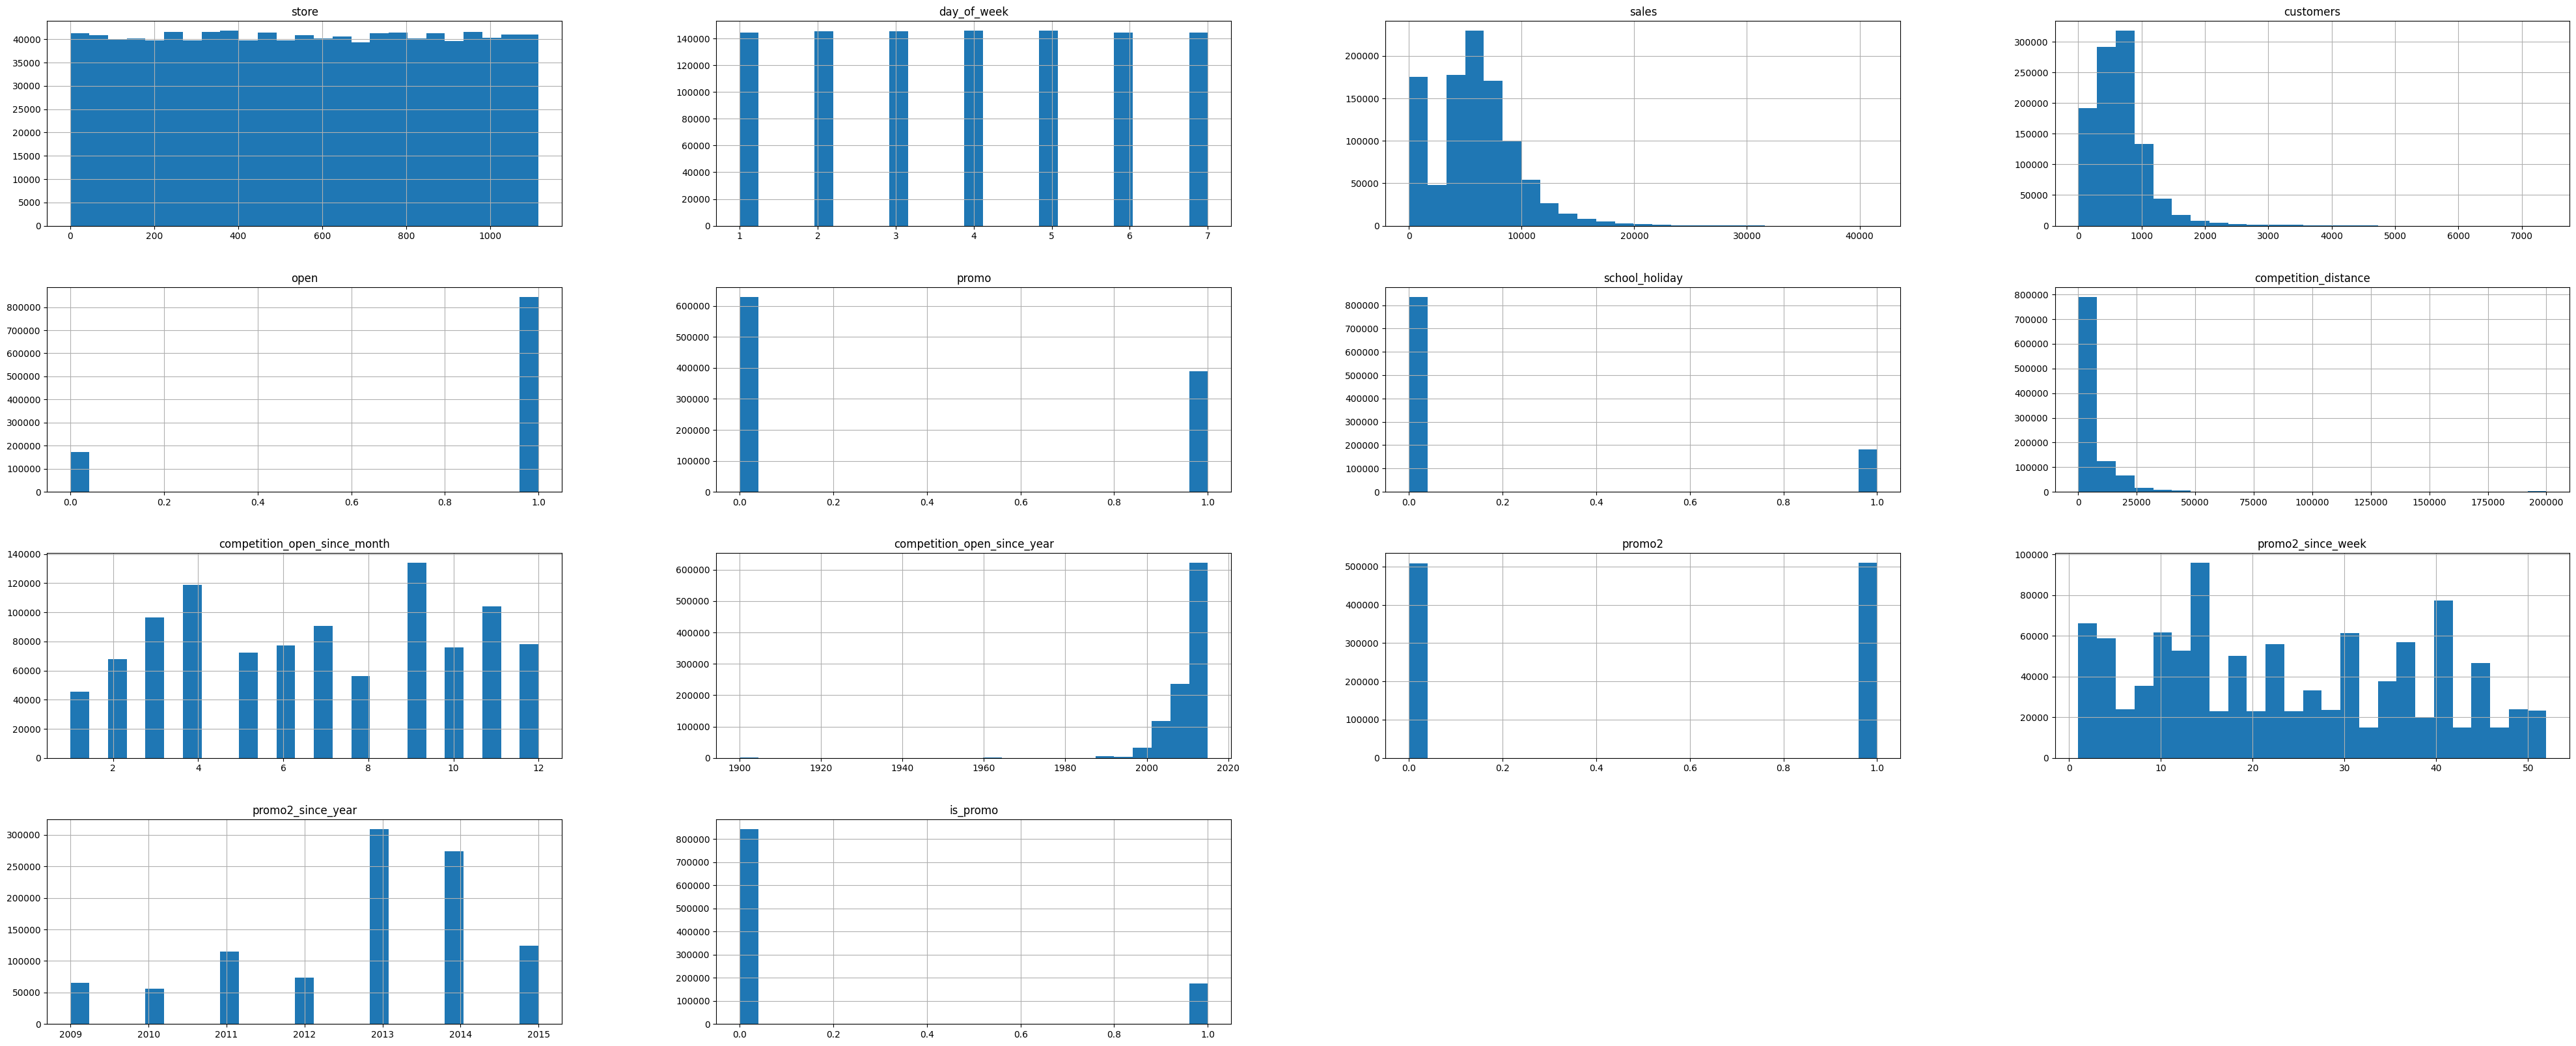

In [27]:

num_attributes.hist(bins=25, figsize=(50,20));

### 4.1.3 Categorical variable

In [28]:
cat_attributes

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul
...,...,...,...,...,...
1017204,a,a,a,"Jan,Apr,Jul,Oct",Jan
1017205,a,c,c,0,Jan
1017206,a,a,c,0,Jan
1017207,a,a,c,0,Jan


/tmp/ipykernel_6468/1761302236.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, 1)


KeyError: 0

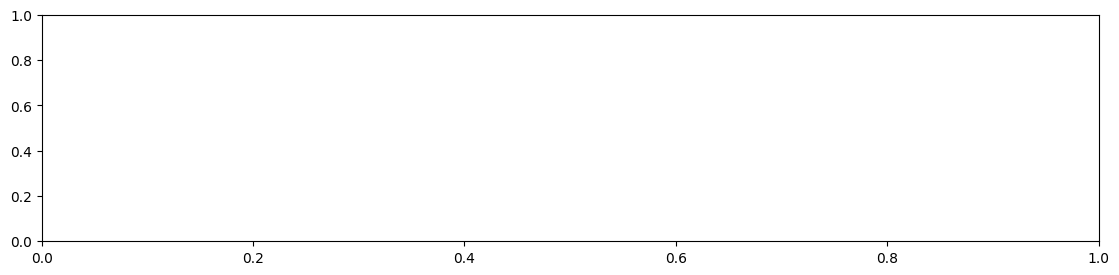

In [36]:
#state_holiday
fig, ax=plt.subplots(figsize=(30, 10))

plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)


#assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais
**Falsa** Lojas com maior sortimento vendem menos (extra)

<AxesSubplot: xlabel='year_week'>

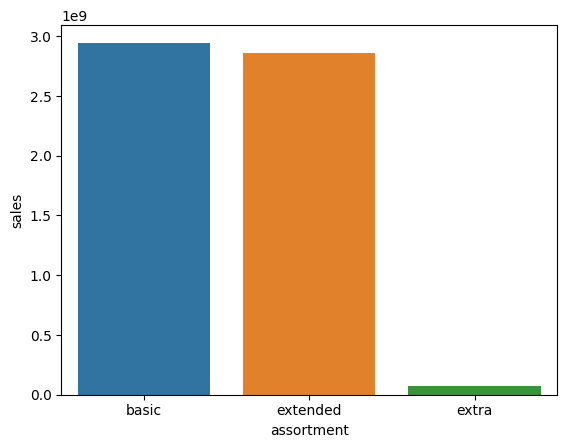

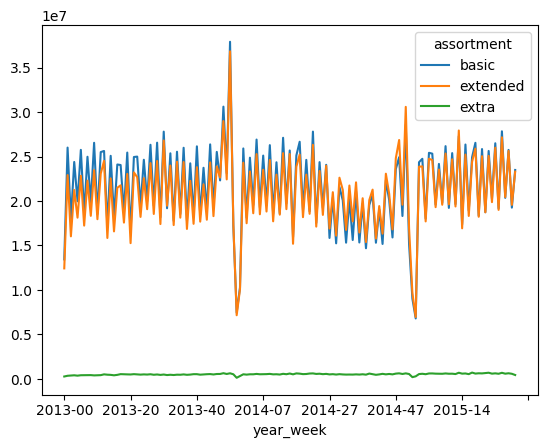

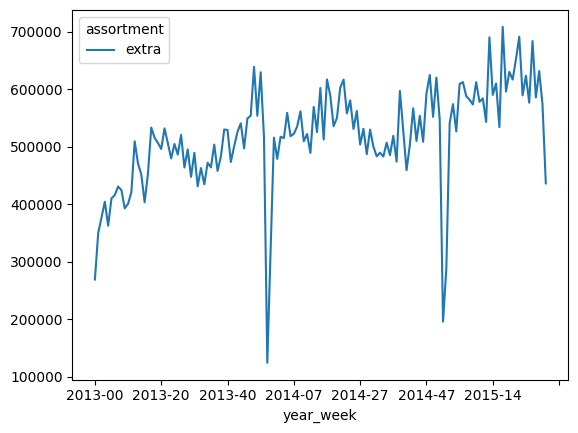

In [37]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos vendem menos
**Falsa** Lojas com competidores mais próximos vendem mais!

/tmp/ipykernel_6468/2446553858.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'), annot=True);


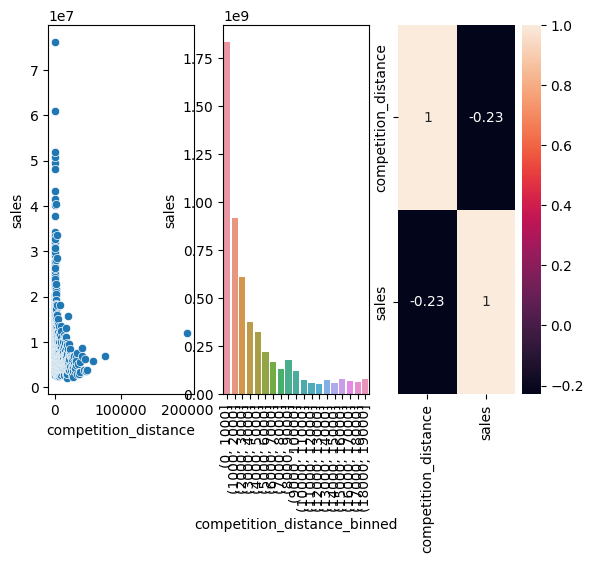

In [38]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

#sns.set(rc = {'figure.figsize':(15,8)})
plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores há mais tempo vendem mais
**Falsa** Lojas com competidores há mais tempo vendem menos! 

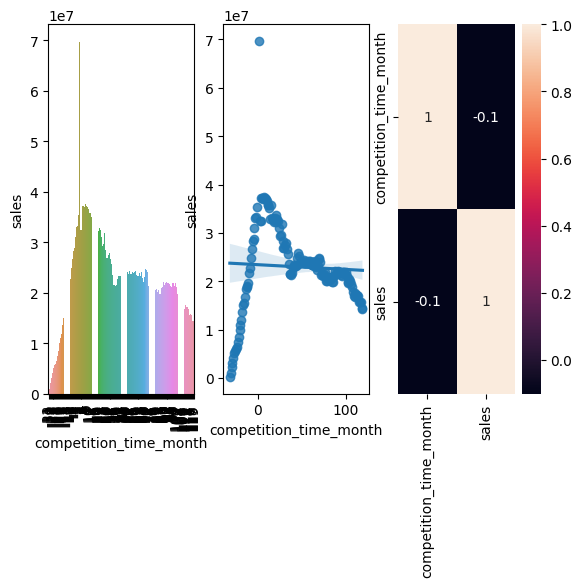

In [39]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);



### H4. Lojas com promoções ativas por mais tempo vendem mais.
**Falsa** Lojas com promoções ativas por mais tempo vendem menos, depois de um tempo de promoção

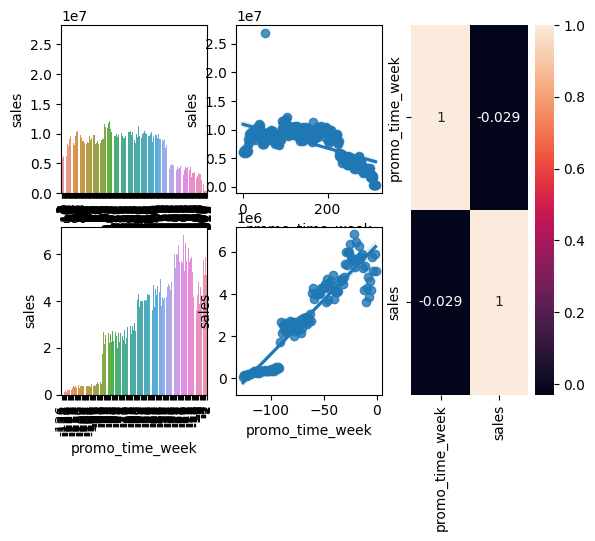

In [40]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s> H5. Lojas com mais dias de promoção devem vender mais </s>
Proximo ciclo do crisp

### H6. Lojas com mais promoções consecutivas vendem mais
**Falsa** Lojas com mais promoções consecutivas vendem menos

In [41]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


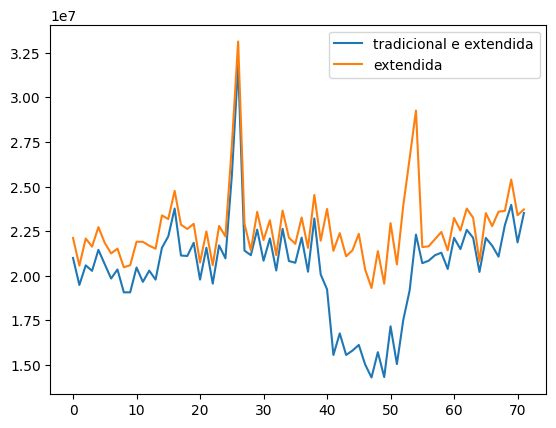

In [42]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['tradicional e extendida', 'extendida'])

### H7. Lojas abertas durante o feriado de Natal vendem mais
**Falsa** No Natal as lojas vendem menos

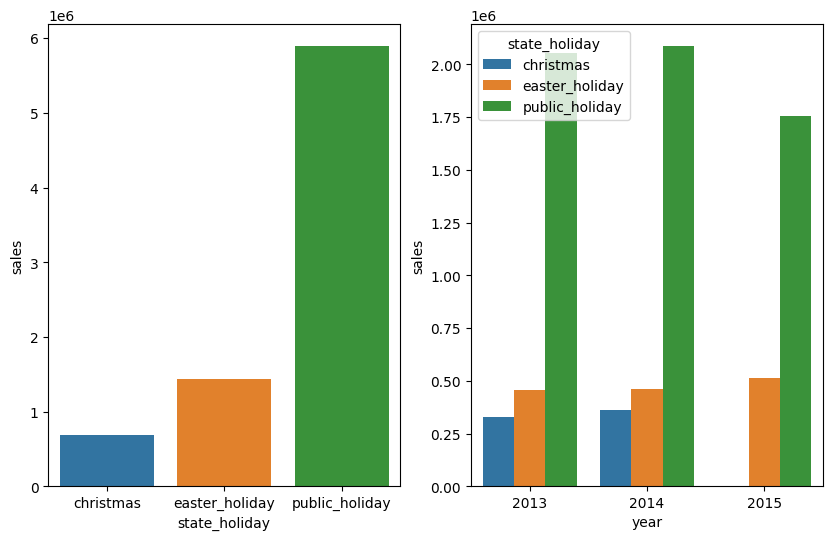

In [43]:
aux = df4[df4['state_holiday'] != 'regular_day']  # as vendas são muito maiores nos dias normais, então tem que tirar para enxergar os feriados

plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);



### H8. Lojas deveriam vender mais ao longo do ano
**Falsa** Lojas estão vendendo menos ao longo do ano

<AxesSubplot: >

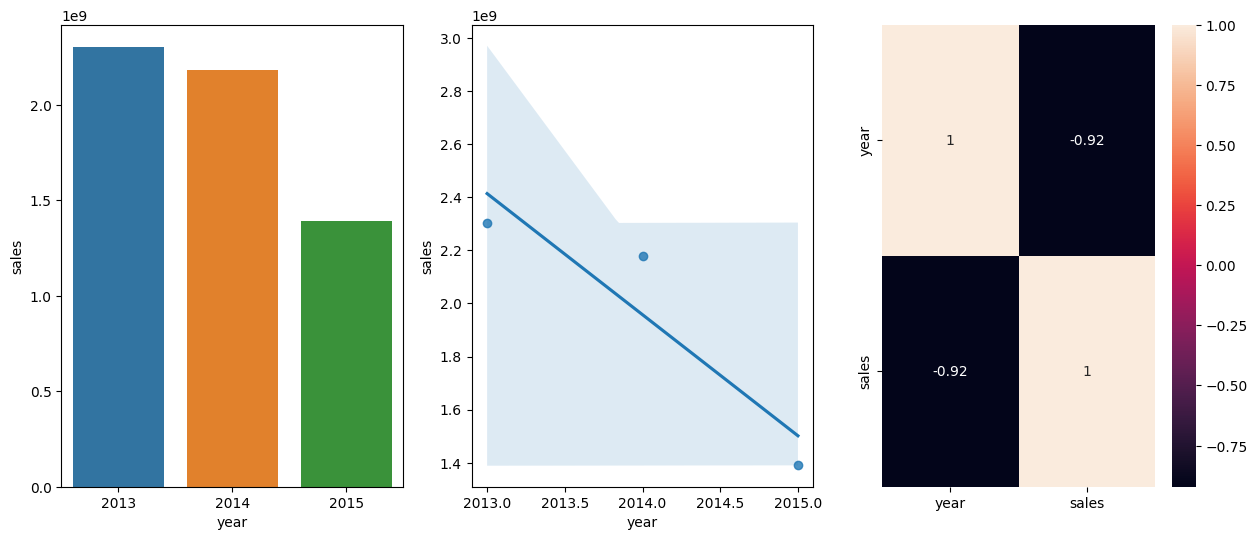

In [44]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H9. Lojas vendem mais no segundo semestre do ano
**Falsa** Lojas vendem menos no segundo semestre do ano

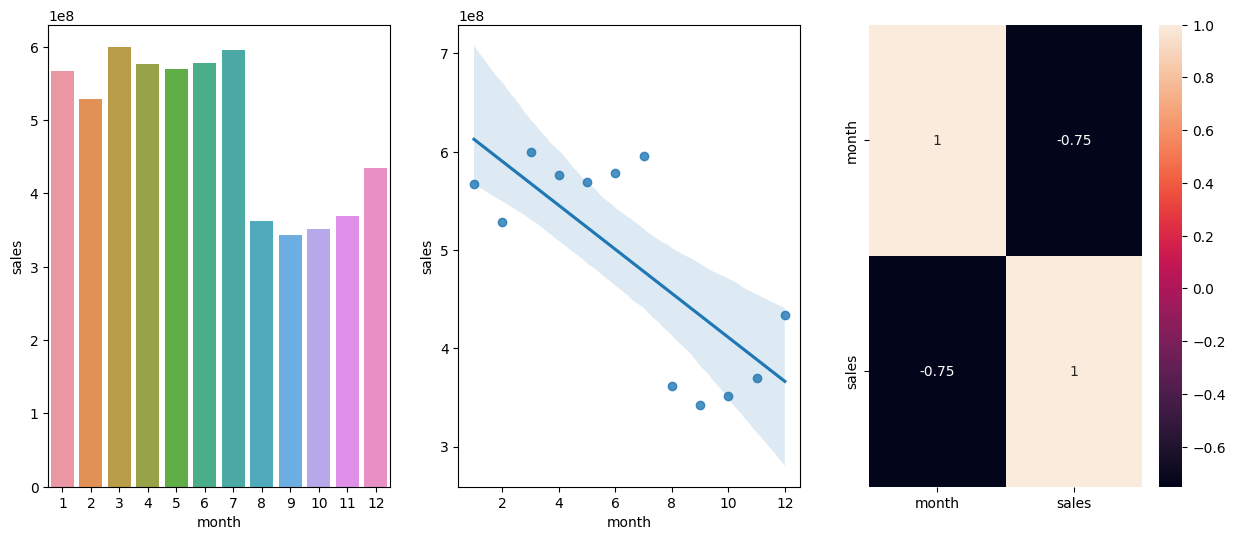

In [45]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas vendem mais depois do dia 10 de cada mês
**Verdadeira** Lojas vendem mais depois do dia 10 de cada mês 

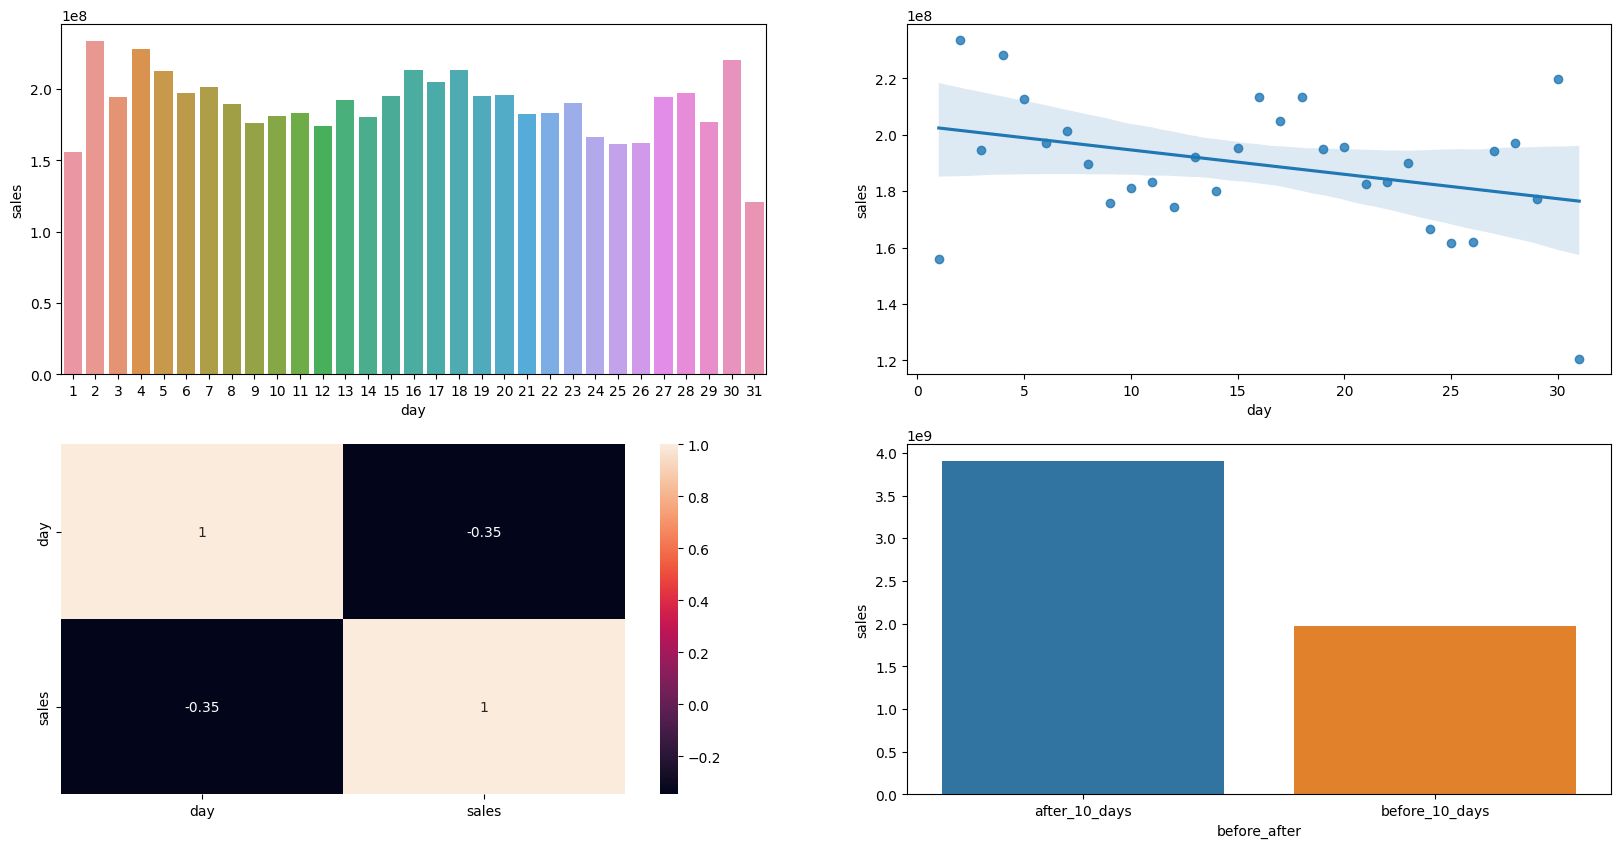

In [46]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### H11. Lojas vendem menos aos finais de semana
**Verdadeira** 

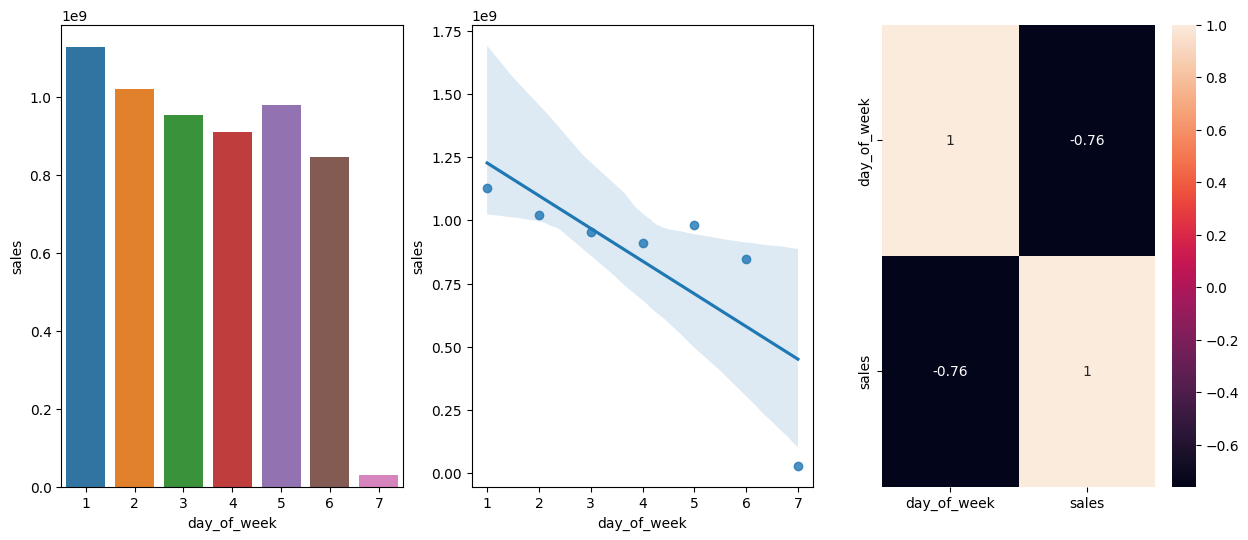

In [47]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Lojas vendem menos durante os feriados escolares
**Verdadeira** Lojas vendem menos durante os feriados escolares, exceto nos períodos de férias (julho e agosto)

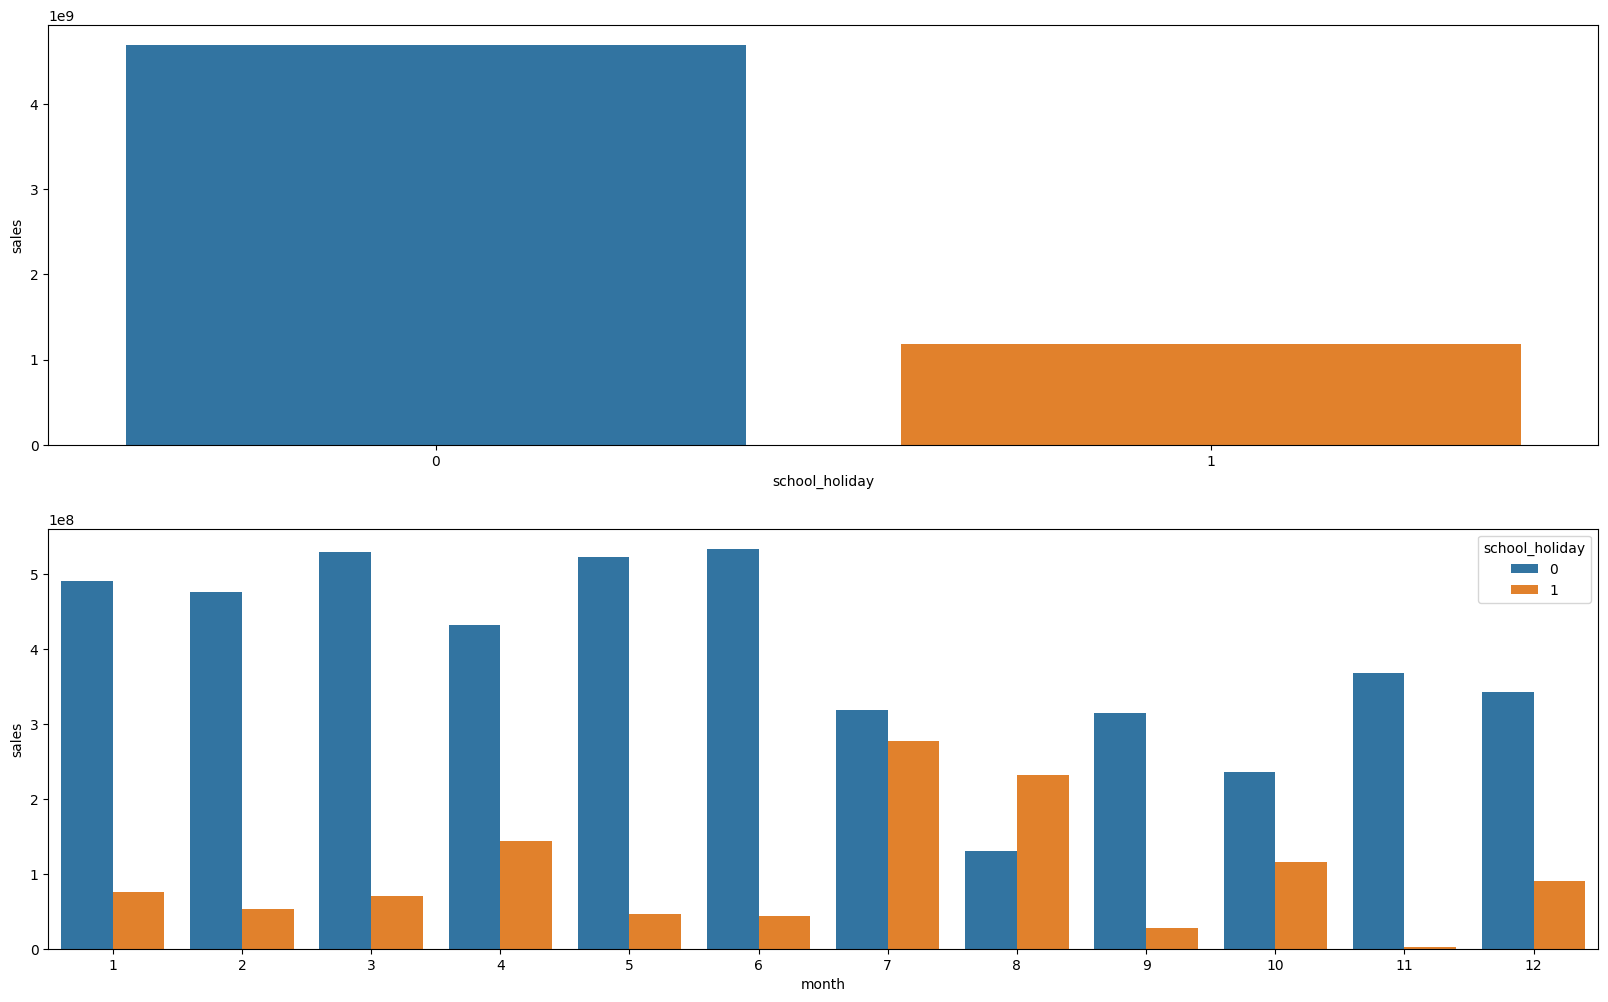

In [48]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.figure(figsize=(20, 12))
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Resumo das hipóteses

In [49]:
tab = [['hipoteses', 'conclusao', 'relevancia'],
      ['H1', 'falsa', 'baixa'],
      ['H2', 'falsa', 'media'],
      ['H3', 'falsa', 'media'],
      ['H4', 'falsa', 'baixa'],
      ['H5', '-', '-'],
      ['H6', 'falsa', 'baixa'],
      ['H7', 'falsa', 'media'],
      ['H8', 'falsa', 'alta'],
      ['H9', 'falsa', 'alta'],
      ['H10', 'verdadeira', 'alta'],
      ['H11', 'verdadeira', 'alta'],
      ['H12', 'verdadeira', 'baixa'],]

print(tabulate(tab, headers='firstrow'))

hipoteses    conclusao    relevancia
-----------  -----------  ------------
H1           falsa        baixa
H2           falsa        media
H3           falsa        media
H4           falsa        baixa
H5           -            -
H6           falsa        baixa
H7           falsa        media
H8           falsa        alta
H9           falsa        alta
H10          verdadeira   alta
H11          verdadeira   alta
H12          verdadeira   baixa


## 4.3 Análise Multivariada

### 4.3.1. Numerical attibutes

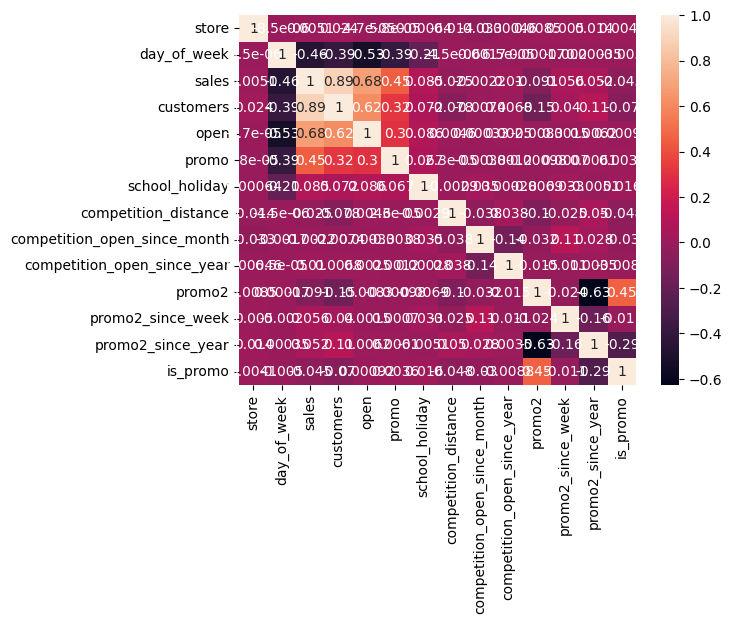

In [50]:
correlation = num_attributes.corr(method='pearson')

#plt.figure(figsize=(20,12))
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical attibutes

In [51]:
a = df4.select_dtypes(include='object')

In [52]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
             'store_type': [a4, a5, a6],
             'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

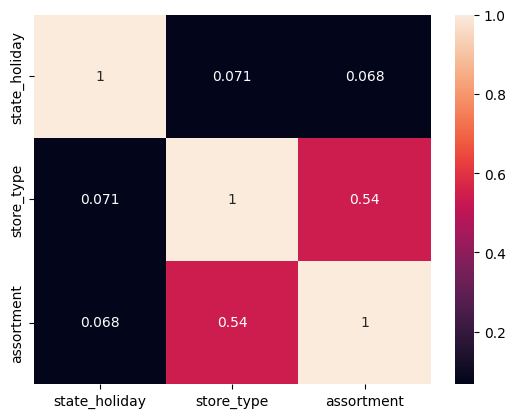

In [53]:
sns.heatmap(d, annot=True);

# 5. Preparação dos Dados

In [90]:
df5 = df4.copy()

## 5.1. Normalização

Não vamos normalizar nada porque não há variáveis normais (abservando as variáveis no ponto 4.1.2), vamos apenas fazer o rescaling.

## 5.2. Rescaling

In [91]:
a = df5.select_dtypes(include = ['int64', 'float64'])

In [92]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance - tem outlier (inserimos uma distância muito maior para os NAs)
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values) #fit_transform calcula os quartis e aplica a formula
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## 5.3. Transformação

### 5.3.1. Encoding 

In [81]:
# ===== Variáveis categóricas =====

# State holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# Store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# Assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Transformação da variável resposta

In [58]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Transformação de Natureza

Calcular seno e cosseno entre do ângulo formado entre os meses de interesse. Cálculo abaixo:

In [59]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. * np.pi/52)))

# 6. Seleção de variáveis

## 6.1. Separando o dataframe em treino e teste

In [61]:
df6 = df5.copy()

In [62]:
df6.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week',
       'state_holiday_christmas', 'state_holiday_easter_holiday',
       'state_holiday_public_holiday', 'state_holiday_regular_day',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos'],
      dtype='object')

In [63]:
# Precisamos excluir as colunas originais das quais derivamos colunas acessórias
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [64]:
df6[['store', 'date']].groupby('store').min().reset_index()
# MENOR DATA = 2013-01-02

df6[['store', 'date']].groupby('store').max().reset_index()
# MAIOR DATA = 2015-07-31

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6 * 7)
#6 * 7 = 6 semanas = 2015-06-19

Timestamp('2015-06-19 00:00:00')

In [65]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training min date: {}'.format(X_train['date'].min()))
print('Training min date: {}'.format(X_train['date'].max()))

print('\nTest min date: {}'.format(X_test['date'].min()))
print('Test min date: {}'.format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training min date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test min date: 2015-07-31 00:00:00


## 6.2. Implementando o Boruta

In [84]:
## Training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel() # vetoriza os valores

## Define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

## Define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.3.1. Melhores variáveis segundo o Boruta

In [62]:
#cols_selected = boruta.support_.tolist() # vai me dar um vetor com numeros

## Best Features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## Not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))



In [66]:
# Adicionamos month_sin e week_of_year_sin pela análise EDA que fizemos antes, assim como tiramos year por este motivo
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# Columns to add
feat_to_add = ['date', 'sales']

# Final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7. Treinando algoritmos de Machine Learning

In [67]:
df7 = df6.copy()

## 7.1. Os 5 algoritmos de ML

In [68]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]


### 7.1.1. Average Model

In [65]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
#tem que transformar os dados de volta aos valores originais (exponencial) porque foram transformados em log mais em cima

baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


### 7.1.2. Linear Regression Model


In [64]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result =  ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

# O RMSE foi bem mais alto que o modelo de média, então a média seria melhor quando comparado os dois.
# O RMSE deu  muito alto, então provavelmente os dados são complexos, não dando para aplicar modelos lineares

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


#### 7.1.2.1. Linear Regression Model - Cross Validation

In [67]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### 7.1.3. Linear Regression Regularized Model - Lasso

In [68]:
# Model
lrr = Lasso(alpha=0.01).fit(x_train, y_train) # O valor de alpha é para deixar os dados em um mesmo range, quanto menor, melhor o valor do rmse, ms demora mais pra rodar 

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result =  ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

# O FENÔMENO NÃO É LINEAR, PRECISAMOS IMPLEMENTAR MODELOS NÃO LINEARES

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


#### 7.1.3.1. Lasso - Cross Validation

In [69]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


### 7.1.4. Random Forest Regressor

In [70]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result =  ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


#### 7.1.4.1. Random Forest Regressor - Cross Validation

In [71]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


### 7.1.5. XGBoost Regressor

In [72]:
# Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result =  ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.423528,0.949439,7330.693347


#### 7.1.5.1. XGBoost Regressor - Cross Validation

In [73]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.2 +/- 588.65,0.95 +/- 0.0,7715.2 +/- 689.51


### 7.1.6. Compare Model's Performance

#### 7.1.6.1. Single Performance

In [74]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.423528,0.949439,7330.693347


#### 7.1.6.2. Real Performance - Cross Validation

In [75]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,7049.2 +/- 588.65,0.95 +/- 0.0,7715.2 +/- 689.51


## 7.2. Cross-Validation

In [66]:
# Rodar esse aqui antes dos CV lá em cima
x_training = X_train[cols_selected_boruta_full]

# 8. Hyperparameter Fine Tuning


O objetivo é encontrar o conjunto de parâmetros que maximiza o aprendizado do modelo

## 8.1. Random Search

In [82]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#}

#quantas iterações:
#MAX_EVAL = 10

In [ ]:
#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
    
    # Choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
    
    # Model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                             n_estimators=hp['n_estimators'],
#                             eta=hp['eta'],
#                             max_depth=hp['max_depth'],
#                             subsample=hp['subsample'],
#                             colsample_bytree=hp['colsample_bytree'],
#                             min_child_weight=hp['min_child_weight'])

    # Não tem 'Prediction' porque vamos fazer o cross validation
    
    # Performance
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat([final_result, result])
    
#final_result

## 8.2. Final Model

In [69]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
}

# Esses são os valores encontrados com o random search que performaram melhor.

In [70]:
# Model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'],
                            eta=param_tuned['eta'],
                            max_depth=param_tuned['max_depth'],
                             subsample=param_tuned['subsample'],
                             colsample_bytree=param_tuned['colsample_bytree'],
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)
    
# Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,764.975639,0.114861,1100.725149


In [73]:
# O pickle salva os parâmetros, daí não precisamos rodar o modelo de novo.

pickle.dump(model_xgb_tuned, open('/home/raianna/Documentos/Repos/ds_em_producao/model_rossmann.pkl', 'wb'))

# 9. Interpretação e tradução de erro

## 9.1. Interpretando e traduzindo o erro

In [83]:
df9 = X_test[cols_selected_boruta_full].reset_index(drop=True)

#rescale
df9['sales'] = df9['sales'].apply(lambda x: np.expm1(x))
df9['predictions'] = np.expm1(yhat_xgb_tuned)

### 9.1.1. Business Performance

In [84]:
# Sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]




In [85]:
'''
Tem loja que é mais difícil fazer a previsão (MAE e MAPE maiores) -- A maior tem MAPE de 60%
'''


df92.sort_values('MAPE', ascending=False)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,108359.789062,104977.608630,111741.969495,3382.180433,0.602768
908,909,220300.078125,212395.141071,228205.015179,7904.937054,0.518675
875,876,194060.812500,189924.534732,198197.090268,4136.277768,0.337730
169,170,201541.687500,200194.421637,202888.953363,1347.265863,0.332923
748,749,206800.953125,205789.192013,207812.714237,1011.761112,0.283049
...,...,...,...,...,...,...
1096,1097,450342.156250,449703.211789,450981.100711,638.944461,0.057761
741,742,301657.531250,301199.145138,302115.917362,458.386112,0.056393
322,323,282916.468750,282488.061009,283344.876491,428.407741,0.056277
666,667,315185.843750,314693.402766,315678.284734,492.440984,0.055487


<AxesSubplot: xlabel='store', ylabel='MAPE'>

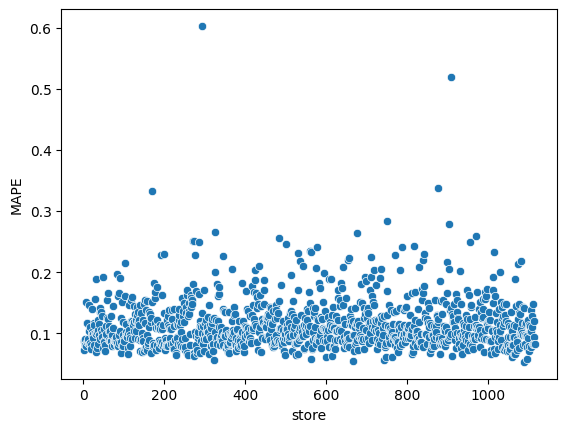

In [86]:
sns.scatterplot(x='store', y='MAPE', data=df92)

### 9.1.2. Total Performance

In [87]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0: 'Values'})

df93['Values'] = df93['Values'].map('R${:,.2f} '.format)

df93

,Scenarios,Values
0,predictions,"R$286,435,616.00"
1,worst_scenario,"R$285,579,535.63"
2,best_scenario,"R$287,291,675.81"


### 9.1.3. Machine Learning Performance 

In [88]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/tmp/ipykernel_6468/192514345.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df9['error'])


<AxesSubplot: xlabel='predictions', ylabel='error'>

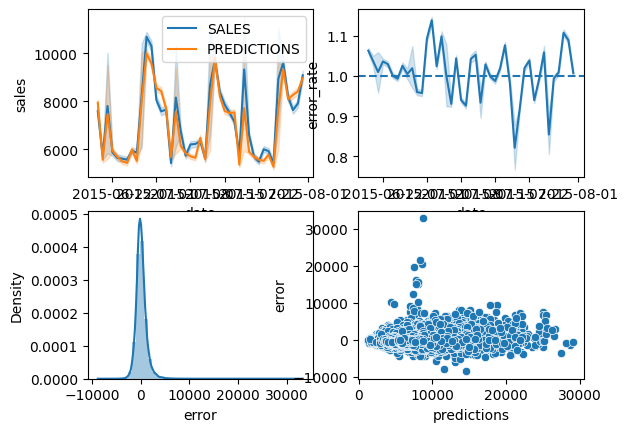

In [89]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(x=df9['predictions'], y=df9['error'], data=df9)

# 10. Deploy do modelo Rossmann

## 10.1. Lista de Tarefas 

1. Criar uma classe com limpeza, transformações e encoding dos dados (Rossmann.py)

2. Criar a API (Handler.py)

3. Criar umm script para testar o request (vai simular o ambiente de produção).

## 10.2. Rossmann Class

In [19]:
import pickle
import inflection
import pandas as pd 
import numpy as np 
import math
import datetime

class Rossmann(object):
    
    def __init__(self):
        self.home_path = '/home/raianna/Documentos/Repos/ds_em_producao/'
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
        
    def data_cleaning(self, df1):

        # Rename columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
                   'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
                   'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))


        df1.columns = cols_new
        
        # Date Types
        df1['date'] = pd.to_datetime(df1['date'])
        
        # Fill NA 
        
        #competition distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)


        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)


        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


        #promo2_since_year 
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


        #promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10:                      'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True) 

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else
                                                                1 if x['month_map'] in                                                                                             x['promo_interval'].split(',') else 0, axis=1)
        
        # change data types
        df1['competition_distance'] = df1['competition_distance'].astype(np.int64)
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)


        return df1
    
    
    
    def feature_engineering(self, df2):
        
       # Year
        df2['year'] = df2['date'].dt.year

        # Month
        df2['month'] = df2['date'].dt.month

        # Day
        df2['day'] = df2['date'].dt.day

        # Week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # Year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # Competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                         month = x['competition_open_since_month'], 
                                                                         day = 1), axis=1)

        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x:                                                         x.days).astype(int)

        # Promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') -                                                      datetime.timedelta(days = 7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # Assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else                                                           'extended')

        # State holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else                                                                   'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else                                                      'regular_day') 
        
        # Filtragem das linhas
        df2 = df2[df2['open'] != 0] 
        
        # Seleção de colunas
        df2 = df2.drop(['open', 'promo_interval', 'month_map'], axis=1)
        
        return df2
    
    
    
    def data_preparation(self, df5):    
    
        # ===== Rescaling =====
        
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)
        
        #promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)
        
        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)

        
        # ===== Encoding =====

        # State holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # Store type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])

        # Assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        
        # ===== Nature transformation =====
        
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. * np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. * np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. * np.pi/52)))
                
            
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                    'competition_open_since_month', 'competition_open_since_year', 'promo2', 
                    'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 
                    'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 
                    'week_of_year_sin', 'week_of_year_cos']

        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        # Prediction
        pred = model.predict(test_data)
        
        # Join pred into the original data (because the client wants the original one to compare, not the modified one)
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso') #retorna em json para a API

## 10.3. API Handler

In [20]:
# Usaremos a biblioteca ==Flask== - ela lida com requests em ambientes web
import pickle
import pandas as pd 
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Loading model
model = pickle.load(open('/home/raianna/Documentos/Repos/ds_em_producao/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST']) #rota, url que vai receber a request, aí vai rodar a função abaixo da request
def rossmann_predict():
    test_json = request.get_json() #request
    
    # Teste se o dado realmente veio na request
    if test_json: #se tiver dado - conversão do json em DF
        
        if isinstance(test_json, dict): #único exemplo
            test_raw = pd.DataFrame(test_json, index=[0]) #vai funcionar se tiver uma única linha
            
        else: #exemplos múltiplos
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # Data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # Feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # Data preparation
        df3 = pipeline.data_preparation(df2)
        
        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3) # vai devolver os dados originais para a pessoa de interesse, e os dados modificados serão utilizados no modelo
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json') #vazio, porque não existe

if __name__ == '__main__':
    app.run('0.0.0.0') #local

    

#if __name__ == '__main__':
# port = os.environ.get('PORT', 5000)
# app.run(host='0.0.0.0', port=port)
# Para fazer o deploy tem que fazer as modificações acima, senão dá erro 503 (não foi possível encontrar a porta)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.10.3:5000
Press CTRL+C to quit


## 10.4. API Tester

In [4]:
# Loading test dataset
df10 = pd.read_csv('/home/raianna/Documentos/Repos/ds_em_producao/test.csv')

In [17]:
# Merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Choose store for prediction
df_test = df_test[df_test['Store'].isin([10, 9, 20])]

# Remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [18]:
# Convert DataFrame to json
data = json.dumps(df_test.to_dict(orient='records')) #transforma o DF em um dicionário (json). json é o formato usado para transferir dados entre sistemas através de uma API


In [23]:
# API call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-raianna.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [25]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [26]:
# Quanto vai vender em 6 semanas
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'],
                                                                       d2.loc[i, 'prediction']))


Store number 9 will sell R$285,236.48 in the next 6 weeks
Store number 10 will sell R$212,788.09 in the next 6 weeks
Store number 20 will sell R$314,606.94 in the next 6 weeks


## 10.5. Deploy no Heroku

- Criar 3 arquivos:

1. Procfile

2. requirements.txt

3. git init